### TODO:

- if hourly returns are noisy: aggregate at smaller frequencies e.g. 12 hours or day - or re-query at smaller frequencies
- shift 'high' & 'low' by one to avoid forward bias for volume / volatility computation
- Plot ACF & PACF to obtain the good number of lags + complete the overleaf counter-part.
- Use GridsearchCV to find the optimal number of trees.

### Assumptions undertaken | done tickets:
- add intercept in design matrix
- removal of all transactions with zero 'close' & removal of first two weeks of each trading period  
    - Assumption: on-chain transactions prior to quotation are left aside.
    - Upsides: allows to remove prices equal to 0 and then remove first two weeks of trading (to avoid possible extreme outliers)
- include back on-chain transactions FROM exchanges and add a dummy variable identifying whether it comes FROM or TO an exchange
    - added a count variable for transactions from one exchange's wallet to another
    - underlying data in its current iteration (as of 21/12/19) only has transactions TO exchanges' wallets and not FROM as i.e. if someone had sent money FROM the exchange TO an unknown wallet

We will consider the GARCH(1,1) with Student-t innovations model of the log-returns process \{$y_t$, $t\in \mathcal{Z}$\}, for $t = 1, \dots, T$:

$$    y_t = \epsilon_t \cdot h_t^{1/2} $$

where $\epsilon_t$ is a sequence of $i.i.d.$ variables $\sim$ ${\mathcal{t}}(\nu)$, 

$$ h_t = \omega + \alpha \cdot y^2_{t-1} + \beta \cdot h_{t-1}$$

for $\omega > 0$; $\alpha,\beta \geq 0$; ${\mathcal{t}}(\nu)$ denotes the Students-t distribution with $\nu$ degrees of freedom. The restriction on the GARCH parameters $\omega$, $\alpha$, $\beta$ guarantee the conditional variance's positivity.

The term $(\alpha + \beta)$ is the degree of persistence in the autocorrelation of the squares which controls the intensity of the clustering in the variance process. With a value close to one, past shocks and past variances will have a longer impact on the future conditional variance.


In [12]:
import numpy as np 
import pandas as pd 
import os

In [13]:
token_data = pd.read_csv('ethereum_erc20_tokens.csv')

In [84]:
def compute_for_token(token_address,
    token_initials,
    initial_date = None
    ):
    
    import pandas as pd
    import numpy as np
    import os
    from datetime import datetime
    import matplotlib.pyplot as plt
    import scipy
    import sklearn
    import time
    import os.path
    from arch import arch_model
    from arch.univariate import ConstantMean, GARCH, StudentsT
    
    from sklearn.model_selection import train_test_split
        
    """######################## Load the dataframe of on-chain transactions #############################"""

    # Read the .csv file containing all exchanges relevant data
    exchange_data = pd.read_csv('all_exchanges.csv')
    
    df = pd.read_csv('./data/{}/raw_big_query.csv'.format(token_initials))
    display(df.shape)
    df.block_timestamp = df.block_timestamp.apply(lambda x: datetime.strptime(x[:-6],'%Y-%m-%d %H:%M:%S') )

    # transactions towards the different exchanges
    exchange_txn_count = (
        df
        .groupby('to_address')
        .count()
        .reset_index()
        .loc[:,['to_address','token_address']]
        .merge(exchange_data, right_on='Address',left_on='to_address')
        .drop(['Address','to_address', 'Txn Count', 'Balance'], axis = 1)
        .rename(columns={'token_address':'transaction_count'})
        .sort_values('transaction_count', ascending=False)
    )
    
    #display(exchange_txn_count.head(20))
    tokens.loc[tokens.initials == token_initials,'most active exchange'] = exchange_txn_count.iloc[0,1]

    # We convert the values (stored as strings) to floats
    df.value=df.value.astype(float)

    exchange_data.Address

    # We create a dummy variable to identify transactions
    # from one exchange's wallet to another   
    df['from_exchange'] = 1 
    # we subselect the dataframe where the 'from_address' is not in the list of exchange addresses 
    df.loc[~df['from_address'].isin(exchange_data.Address), 'from_exchange'] = 0
    
    trans = df
    print('We found {} transactions towards exchanges.'.format( df.shape[0]) )
    tokens.loc[tokens.initials == token_initials,'transactions to exchanges'] = df.shape[0]
        
    address_tran_counts = (
        trans
        .groupby('from_address')
        .count()
        .sort_values(by='value', ascending=False)
        .to_address
    )
    
    trans = (
        df
        .sort_values('block_timestamp')
        .reset_index()
        .drop('index', axis=1)
    )
    
    trans = trans.rename(columns={'block_timestamp': 'time'})

    # We transform the times UTC to naive times
    trans.time = trans.time.values

    min_date = datetime.timestamp(trans.time[0])
    max_date = datetime.timestamp(trans.time.iloc[-1])
    max_date, min_date
            
    """######################## Load the dataframe of off-chain transactions #############################"""  
    
    price_raw = pd.read_csv('./data/{}/raw_crypto_compare.csv'.format(token_initials))
    price = price_raw
    price = price.sort_values('time').reset_index()

    price.loc[:,'time_readable'] = (
        price
        .time
        .apply(lambda x:datetime.utcfromtimestamp(x).strftime('%Y-%m-%d %H:%M:%S') )
    )
    
    # We convert the price dates into datetime objects
    price.time=price.time.apply(lambda x: datetime.fromtimestamp(x))

    if initial_date:
        price = price.loc[price.time >initial_date]

    # "volumeto" means the volume in the currency that is being traded
    # "volumefrom" means the volume in the base currency that things are traded into.
    price = (
        price
        .drop(
            ['time_readable', 'conversionSymbol','conversionType', 'open', 'volumefrom','index'],
            axis=1
        )
    )
    
    # We consider the BTC volume as what we refer to as 'volume'
    price = (
        price
        .rename(columns={'volumeto':'volume'}) 
        .drop('Unnamed: 0', axis=1)
    )
    
    # filters out all zero prices
    price = price[(price[['close']] != 0).all(axis=1)]
    print('We have {} observations.'.format( price.shape[0]) )
    
    '''############################ COMPUTE ON-CHAIN AGGREGATES ##################################'''
    
    # We compute the returns of the closing prices
    price.loc[:,'returns'] = np.log(price['close']).diff()
        
    # In order to transform dates to non local time
    trans.loc[:,'time']= trans.time.values

    min_time, max_time = price.time.iloc[[0,-1]].values
    
    # We only keep the transactions for which we have price data
    trans = trans.loc[(trans['time'] >= min_time)]   
    
    # We create bins of hourly intervals and we aggregate the on-chain transactions in the bins
    cut = pd.cut(trans.time, bins= price.time, duplicates='drop')
    

    '''
    GOAL: merge on-chain and off-chain datasets.
    PROCEDURE:
    Group by the number of tokens exchanged and compute the sum
    and count the number of individual transactions.
    Yields: 'onchain_volume' & 'onchain_trans'
    Perform the same by grouping by 'from_exchange' dummy variable
    to get the number of transactions coming from other exchanges
    '''
    data = price
    
    for _GROUPBY in ['value','from_exchange']:
        # sum variable of FROM exchanges transactions
        trans_cut = trans.groupby(cut)[_GROUPBY].aggregate(['count','sum'])
        # We show 5 examples of intervals for readability
        trans_cut.sample(5)
        trans_cut = trans_cut.reset_index()
        trans_cut.time = trans_cut.time.apply(lambda x:x.right)
        trans_cut.time = pd.to_datetime(trans_cut.time)
        
        data = (
            trans_cut
            .merge(data, left_on='time', right_on='time')
        )
        
        if _GROUPBY == 'value':
            data = data.rename(columns={'sum':'onchain_volume', 'count':'onchain_trans'})
        else:
            data = (
                data
                .rename(columns={'sum':'from_exchanges_transactions'})
                .drop('count', axis=1)
            )
    
    hours_in_day = 24
    days_in_week = 7
    hours_in_week = days_in_week * hours_in_day
    data = data[2 * hours_in_week:]
    
    display(data.tail(20))
    
    '''############################ GARCH PROCEDURE ##################################'''

    am = ConstantMean(data['returns'][1:])
    am.volatility = GARCH(1, 0, 1)
    am.distribution = StudentsT()

    res = am.fit(disp = 'off', update_freq = 7)
    display(res)
    GARCH_param = (
        pd
        .DataFrame(
            {
                'Asset' : 'Stock',
                'omega' : [res.params['omega']],
                'alpha' : [res.params['alpha[1]']],
                'beta' : [res.params['beta[1]']],
                'nu' : [res.params['nu']]                            
            }
        )
    )
    
    GARCH_param.set_index('Asset', inplace = True)

    display(GARCH_param)
    display(res.summary())   


    '''############################ DATA CLEANING ##################################'''
    # We remove the rows where one value is missing
    data = (
        data
        .replace([np.inf, -np.inf], np.nan) # remove rows with infinite values
        .dropna()
        .reset_index()
        .drop('index', axis=1)
    )
    
    lower_bound = -100
    upper_bound = 100
    data = data.loc[(data['returns'] >= lower_bound) & (data['returns'] <= upper_bound)]
    data.sort_values('time')   


    '''############################ PLOTS ##################################'''


    nb_figures = 6
    # The style of the figure can be set globally using the matplotlib rc parameters.
    plt.rcParams['axes.grid'] = True
    plt.rcParams["figure.figsize"] = [10,6]
    
    fig, (ax1,ax11, ax5, ax2, ax3, ax4, ) = plt.subplots(nb_figures, 1, figsize=(15,10), sharex =True)
    for ax in fig.axes:
        plt.sca(ax)
        plt.xticks(rotation=90)
    plt.suptitle('{} data'.format(token_initials))
    plt.subplots_adjust(hspace = 0.25) # the amount of height reserved for space between subplots
    ax1.set_title('Price evolution in BTC')
    ax1.plot(data.time, data.close)
    
    ax11.set_title('Hourly return of price of token')
    ax11.plot(data.time, data.returns)
    ax11.set_ylim((-0.3,0.3))
    
    ax5.set_title('Volume evolution in BTC')
    ax5.plot(data.time, data.volume)
    
    ax2.set_title('Rolling 7-day exchange volume evolution in BTC')
    ax2.plot(data.time,data.volume.rolling(24*7).mean())
    
    ax3.set_title('Rolling 7-day on-chain transaction count to exchanges')
    ax3.plot(data.time,data.onchain_trans.rolling(24*7).mean())
    
    ax4.set_title('Rolling 7-day on-chain volume evolution in BTC')
    ax4.plot(data.time,data.onchain_volume.rolling(24*7).mean())
    
    # Rotates and right aligns the x labels, and moves the bottom of the
    # Axes up to make room for them
    fig.autofmt_xdate()
    
    plt.savefig('./data/{}/all_plots.png'.format(token_initials))

    data['intercept'] = 1
    
    '''############################ DESIGN MATRICES ##################################'''
    
    y_returns = data.returns.values
    y_volume = data.volume.values
    
    X_returns = (
        data
        .loc[
            :,
             [
              'intercept', 'onchain_trans', 'onchain_volume',
              'high', 'low', 'volume', 'from_exchanges_transactions'
             ]
            ]
        .values
    )
    
    X_volume = (
        data
        .loc[
            :,
            [
                'intercept', 'onchain_trans', 'onchain_volume',
                'high', 'low', 'from_exchanges_transactions'
            ]
        ]
        .values
    )
    
    '''
    The following lines creates an iterator to iterate by pair of y_ | x_
    We would like to run for pairs of y_returns, X_returns, likewise for volume
    '''
    lis = (y_returns, X_returns, y_volume, X_volume)
    it = iter(lis)
    
    for y in it:
        
        X = next(it)
        
        from sklearn.impute import SimpleImputer

        results = {}
        X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.33, random_state=2, shuffle=False)
        X_train_train, X_train_test, y_train_train, y_train_test = train_test_split(X_train,y_train,test_size=0.33, random_state=2)
        
        from sklearn.preprocessing import StandardScaler
        scaler = StandardScaler()
        scaler.fit(X_train_train)

        X_train_train = scaler.transform(X_train_train)
        X_train_test = scaler.transform(X_train_test)
        X_test = scaler.transform(X_test)
        
        '''############################ Linear Regression ##################################'''
        from sklearn.linear_model import LinearRegression

        reg = LinearRegression().fit(X_train_train, y_train_train)
              
        # If the the series is Returns, set column_name to 'returns'
        # Else set the column name to 'off-chain volume'
        col_name = 'returns' if np.array_equiv(X, X_returns) else 'off-chain volume' 
        # col_name = 'returns' if (X == X_returns).all() else 'off-chain volume' 
        
        results['linear regression score of ' + col_name] = reg.score(X_test, y_test)
        print('linear regression score of ' + col_name, reg.score(X_test, y_test))

        reg_score = reg.score(X_test, y_test)
        tokens.loc[tokens.initials == token_initials,'linear regression score of '+col_name] = reg_score

        # Start the scatter plots here
        nb_rows = 2
        nb_columns = 1
        
        fig, (ax_linreg, ax_tree) = plt.subplots(nb_rows, nb_columns, figsize=(15,10), sharex =True)
        for ax in fig.axes:
            plt.sca(ax)
            plt.xticks(rotation=90)
        plt.suptitle('{} linear regression and RF Regressor for '.format(token_initials) + col_name)
        ax_linreg.scatter(y_test, reg.predict(X_test))
        ax_linreg.plot(y_test,y_test, 'k')
        ax_linreg.set_title(
            'Linear regression of ' + col_name +
            ' prediction vs. true validation data token {}\n score: {:.3f} '
            .format(token_initials, reg_score)
        )
        # Rotates and right aligns the x labels, and 
        # Moves the bottom of the axes up 
        # To make room for them
        fig.autofmt_xdate()
        
        '''############################ RF Regressor ##################################'''
        from sklearn.ensemble import RandomForestRegressor
        
        clf = RandomForestRegressor(n_estimators = 100)
        clf = clf.fit(X_train_train, y_train_train)
        results['RF Regressor score of ' + col_name] = clf.score(X_test,y_test)
        print('RF Regressor score of ' + col_name, clf.score(X_test,y_test) )
        clf_score = clf.score(X_test,y_test) 

        tokens.loc[tokens.initials == token_initials,'RF Regressor score of ' + col_name] = clf_score

        ax_tree.scatter(y_test, clf.predict(X_test))
        ax_tree.plot(y_test,y_test, 'k')
        ax_tree.set_title(
            'RF Regressor prediction of ' + col_name +
            ' vs. true validation data token {}\n score:{:.3f} '
            .format(token_initials, clf_score)
        )
        # Rotates and right aligns the x labels, and 
        # Moves the bottom of the axes up 
        # To make room for them
        fig.autofmt_xdate()
    
        plt.savefig('./data/{}/regression_plots.png'.format(token_initials))
        plt.savefig('./data/{}/'.format(token_initials) + col_name + '_regression_plots.png')


### Run the program

In [85]:
tokens = os.listdir('data')

In [86]:
# We keep the tokens for which we have both on-chain and off-chain data
tokens = pd.Series(tokens)
keep = (
    tokens
    .apply(lambda x: 
           os.path.exists('data/{}/raw_big_query.csv'.format(x)) 
           and 
           os.path.exists('data/{}/raw_crypto_compare.csv'.format(x))
    )
)
remove_tokens = tokens.loc[~keep]
tokens = tokens.loc[keep]
tokens = token_data.merge(tokens.to_frame(), left_on='initials', right_on=0).drop(0, axis=1) #token_data contains all info
tokens.loc[:,'linear model score'] = 0
tokens.loc[:,'transactions to exchanges'] = 0
tokens = tokens.drop(['holders','daily_volume','price'], axis = 1)
#tokens.dtypes

### Test procedure

(173535, 9)

We found 173535 transactions towards exchanges.
We have 19966 observations.


,time,from_exchanges_transactions,onchain_trans,onchain_volume,close,high,low,volume,returns
19945,2019-11-19 19:00:00,0,4,1.504055e+22,0.000031,0.000031,0.000031,5.325,0.014085
19946,2019-11-19 20:00:00,0,3,1.902244e+22,0.000031,0.000032,0.000031,8.695,-0.009582
19947,2019-11-19 21:00:00,0,1,1.699400e+22,0.000031,0.000031,0.000031,4.954,-0.000321
19948,2019-11-19 22:00:00,0,5,8.304460e+21,0.000031,0.000031,0.000031,6.108,0.003845
19949,2019-11-19 23:00:00,0,3,1.698259e+21,0.000031,0.000032,0.000031,5.414,0.006693
19950,2019-11-20 00:00:00,0,6,4.483986e+22,0.000032,0.000032,0.000031,18.390,0.014194
19951,2019-11-20 01:00:00,0,2,1.567987e+22,0.000032,0.000032,0.000032,7.836,0.000939
19952,2019-11-20 02:00:00,3,7,4.527528e+23,0.000032,0.000032,0.000032,7.112,0.005305
19953,2019-11-20 03:00:00,0,3,1.799785e+22,0.000032,0.000032,0.000032,7.619,-0.002805
19954,2019-11-20 04:00:00,0,2,3.411723e+22,0.000032,0.000032,0.000032,3.474,0.004671


C:\ProgramData\Anaconda3\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning: 
The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


                        Constant Mean - GARCH Model Results                         
Dep. Variable:                      returns   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                            GARCH   Log-Likelihood:                62599.8
Distribution:      Standardized Student's t   AIC:                          -125190.
Method:                  Maximum Likelihood   BIC:                          -125150.
                                              No. Observations:                19628
Date:                      Sat, Dec 21 2019   Df Residuals:                    19623
Time:                              13:43:00   Df Model:                            5
                                  Mean Model                                  
                  coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------

,omega,alpha,beta,nu
Asset,,,,
Stock,0.000005,0.2,0.78,4.145944


<class 'statsmodels.iolib.summary.Summary'>
"""
                        Constant Mean - GARCH Model Results                         
====================================================================================
Dep. Variable:                      returns   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                            GARCH   Log-Likelihood:                62599.8
Distribution:      Standardized Student's t   AIC:                          -125190.
Method:                  Maximum Likelihood   BIC:                          -125150.
                                              No. Observations:                19628
Date:                      Sat, Dec 21 2019   Df Residuals:                    19623
Time:                              13:43:00   Df Model:                            5
                                  Mean Model                                  
==============================================================================
                  coef    std err          t      P>|t|       95.0% Conf. Int.
------------------------------------------------------------------------------
mu         -5.1162e-05  4.490e-05     -1.139      0.255 [-1.392e-04,3.685e-05]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega      4.5886e-06  5.944e-09    771.999      0.000 [4.577e-06,4.600e-06]
alpha[1]       0.2000  7.314e-03     27.346 1.215e-164     [  0.186,  0.214]
beta[1]        0.7800  8.008e-03     97.408      0.000     [  0.764,  0.796]
                              Distribution                              
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
nu             4.1459      0.114     36.463 4.239e-291 [  3.923,  4.369]
========================================================================

Covariance estimator: robust

WARNING: The optimizer did not indicate successful convergence. The message was
Inequality constraints incompatible. See convergence_flag.
"""

linear regression score of returns -0.004378427851746913
RF Regressor score of returns -0.4594505989989903
linear regression score of off-chain volume -0.1131397020478131
RF Regressor score of off-chain volume 0.17203855938532953


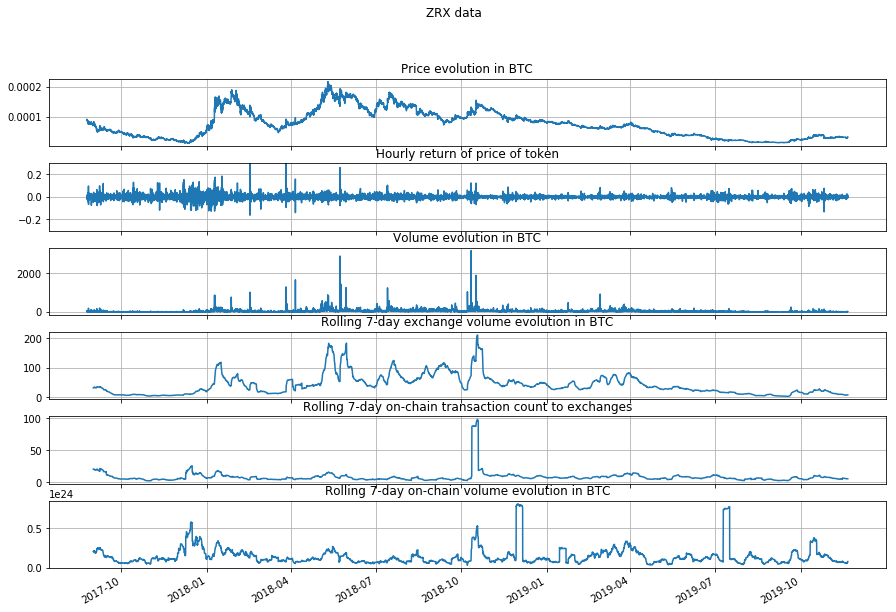

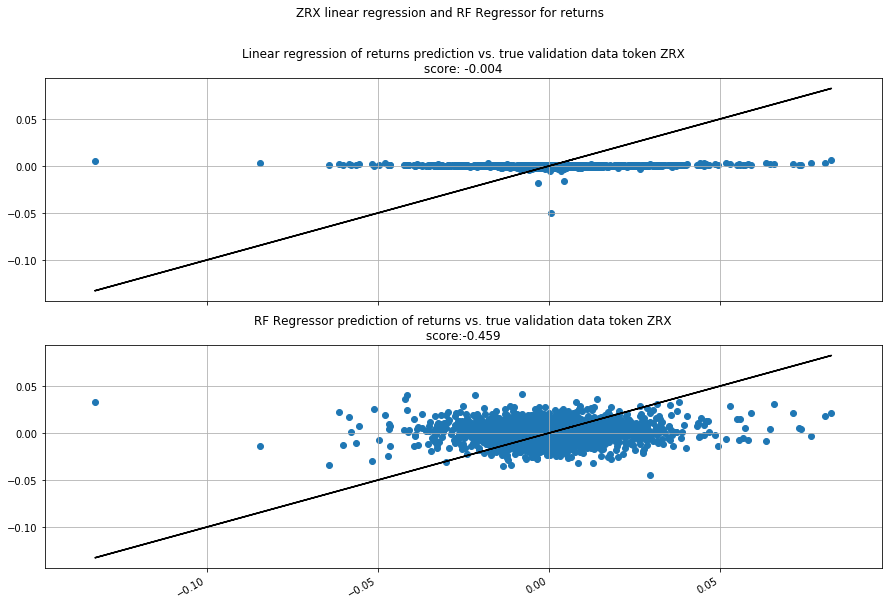

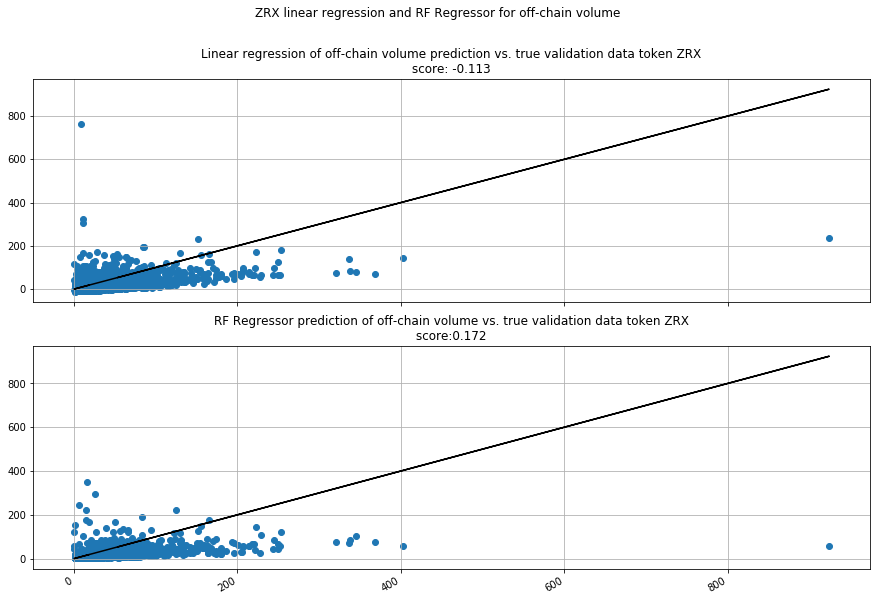

In [87]:
# hardcode our test procedure
compute_for_token('0xe41d2489571d322189246dafa5ebde1f4699f498', 'ZRX')

### Run the program for all tokens

In [ ]:
for i in range(len(tokens.initials)):
    try:
        print(i)
        compute_for_token(tokens.address[i], tokens.initials[i])
    except Exception as e:
        print(e)

In [ ]:
tokens.to_csv('tokens_all_regressions.csv', index=False)
tokens.head(1)

### Printing results in LaTeX

In [ ]:
import pandas as pd
tokens = pd.read_csv('tokens_all_regressions.csv')
tokens.head(3)

In [ ]:
# Make a proper format to improve clarity
tokens['market_cap'] = (
    tokens['market_cap']
    .str.replace(',', '')
    .str.replace('$', '')
    .astype(int)
)
tokens = tokens.sort_values('market_cap', ascending=False)
tokens.head(3)

In [ ]:
tokens['market_cap'] = (tokens['market_cap']/1000000).apply(lambda x: '${:,.2f}M'.format(x))
tokens.head(3)

### Print ML techniques scores

In [ ]:
nb_decimals_to_round_to = 2 

print(tokens
      .drop(['address','description',
             'initials','linear model score',
             'most active exchange','transactions to exchanges'], axis=1)
      .round(
          {
              'RF Regressor score of returns': nb_decimals_to_round_to,
              'RF Regressor score of off-chain volume': nb_decimals_to_round_to,
              'linear regression score of returns': nb_decimals_to_round_to,
              'linear regression score of off-chain volume': nb_decimals_to_round_to,
          }
      )
      .reset_index(drop=True)
      .rename(columns = 
              {
                  'RF Regressor score of returns' : 'RF Regressor returns score',
                  'RF Regressor score of off-chain volume' : 'RF Regressor volume score',
                  'linear regression score of returns' : 'Lin-reg returns score',
                  'linear regression score of off-chain volume' : 'Lin-reg volume score'                  
              }
       )
      .to_latex()
)

### Print the descriptions

In [ ]:
lzt = tokens.columns.tolist()
lzt.remove('description')
lzt.remove('name')
pd.options.display.max_colwidth = 100
print(tokens
      .drop(lzt, axis=1)
      .to_latex()
)